# 1. introduccir base de datos entrenamiento 

In [1]:
#!pip install pandas openpyxl

In [2]:
import pandas as pd

# Especifica la ruta del archivo Excel
archivo_excel = "C:\\Users\\USER\\Documents\\CIENCIA DE DATOS\\Proyecto aplicado\\SENTIMINIENTO CHAT GPT\\BASE DE DATOS ENTRENAMIENTO2.xlsx"

# Lee el archivo Excel en un DataFrame
df = pd.read_excel(archivo_excel, engine='openpyxl')

# Muestra las primeras filas del DataFrame
print (df)


     Unnamed: 0                                             Título  \
0             1         Bogotá Refuerza la Participación Ciudadana   
1             2       La Inequidad Persiste en el Sistema Judicial   
2             3  Libertad de Prensa: Un Pilar para la Paz en Bo...   
3             4  Sistema Electoral en Crisis: ¿Dónde Está la Ju...   
4             5       Educación para la Democracia en las Escuelas   
..          ...                                                ...   
338         339  Impacto Mixto de las Políticas de Seguridad Pú...   
339         340  Desafíos en la Aplicación de Políticas para la...   
340         341  El Impacto de las Iniciativas para el Desarrol...   
341         342  Problemas en la Implementación de Políticas de...   
342         343  Impacto Mixto de las Políticas de Protección d...   

                                                 Texto Evaluación  
0    En un esfuerzo por fortalecer la democracia, l...   Positivo  
1    A pesar de los esf

# 2. evaluar el modelo con beto

In [3]:
#!pip install transformers torch

In [4]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Cargar el tokenizer y el modelo BETO preentrenado
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', num_labels=3)

# Mapear números de predicción a etiquetas de sentimiento
etiquetas = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

# Función para predecir el sentimiento
def predecir_sentimiento(texto):
    inputs = tokenizer(texto, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    return etiquetas.get(pred, 'Desconocido')

# Aplicar la función a la columna de texto
df['Sentimiento'] = df['Texto'].apply(predecir_sentimiento)

df

# Recuento de sentimientos
recuento_sentimientos = df['Sentimiento'].value_counts()

# Mostrar el recuento de sentimientos
print(recuento_sentimientos)



c:\Users\USER\Documents\CIENCIA DE DATOS\NPL\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\USER\Documents\CIENCIA DE DATOS\NPL\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to b

Sentimiento
Negativo    211
Neutro      129
Positivo      3
Name: count, dtype: int64


In [5]:
import pandas as pd

# Supongamos que df ya tiene las columnas 'Evaluación' y 'Sentimiento'

# Comparar las columnas 'Evaluación' y 'Sentimiento' y contar coincidencias
coincidencias = df[df['Evaluación'] == df['Sentimiento']].shape[0]

# Mostrar el número de coincidencias
print(f"Número de coincidencias entre 'Evaluación' y 'Sentimiento': {coincidencias}")

# Mostrar el número total de filas para comparar con las coincidencias
total_filas = df.shape[0]
print(f"Número total de filas: {total_filas}")

# Calcular el porcentaje de coincidencias
porcentaje_coincidencias = (coincidencias / total_filas) * 100
print(f"Porcentaje de coincidencias: {porcentaje_coincidencias:.2f}%")


Número de coincidencias entre 'Evaluación' y 'Sentimiento': 132
Número total de filas: 343
Porcentaje de coincidencias: 38.48%


# 3. Entrenar el modelo

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
from sklearn.utils import resample

# Mapear las etiquetas a números
etiquetas = {'Negativo': 0, 'Neutro': 1, 'Positivo': 2}
df['Etiqueta'] = df['Evaluación'].map(etiquetas)
df = df.dropna(subset=['Etiqueta'])
df['Etiqueta'] = df['Etiqueta'].astype(int)

# Asegurar que las clases estén balanceadas
# Submuestreo o sobremuestreo para balancear las clases
min_count = df['Etiqueta'].value_counts().min()

# Submuestreo de clases mayoritarias (o sobremuestreo si prefieres)
df_negativo = resample(df[df['Etiqueta'] == 0], replace=False, n_samples=min_count, random_state=42)
df_neutro = resample(df[df['Etiqueta'] == 1], replace=False, n_samples=min_count, random_state=42)
df_positivo = resample(df[df['Etiqueta'] == 2], replace=False, n_samples=min_count, random_state=42)

# Concatenar los subconjuntos balanceados
df_balanceado = pd.concat([df_negativo, df_neutro, df_positivo])

# Preparar los datos para el entrenamiento
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

def tokenize_function(examples):
    return tokenizer(examples['Texto'], padding="max_length", truncation=True, max_length=512)

# Convertir DataFrame a Dataset
dataset = Dataset.from_pandas(df_balanceado[['Texto', 'Etiqueta']])
dataset = dataset.map(tokenize_function, batched=True)

# Renombrar la columna de etiquetas a 'labels'
dataset = dataset.rename_column('Etiqueta', 'labels')

# Dividir los datos en entrenamiento y validación
train_dataset = dataset.shuffle(seed=42).select([i for i in range(int(len(dataset)*0.8))])
eval_dataset = dataset.shuffle(seed=42).select([i for i in range(int(len(dataset)*0.8), len(dataset))])

# Cargar el modelo preentrenado
model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', num_labels=3)

# Definir los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',          # Directorio para guardar los resultados
    num_train_epochs=3,              # Número de épocas
    per_device_train_batch_size=8,   # Tamaño del batch
    per_device_eval_batch_size=8,    # Tamaño del batch para evaluación
    warmup_steps=50,                # Número de pasos de calentamiento
    weight_decay=0.01,               # Decaimiento del peso
    learning_rate=5e-5,              # Tasa de aprendizaje
    logging_dir='./logs',            # Directorio para los logs
    logging_steps=50,
    evaluation_strategy="epoch",     # Evaluar al final de cada época
    save_strategy="epoch",           # Guardar el modelo al final de cada época
    load_best_model_at_end=True,     # Cargar el mejor modelo al final
    seed=42,                         # Fijar la semilla para reproducibilidad
)

# Definir el Trainer
trainer = Trainer(
    model=model,                         # El modelo a entrenar
    args=training_args,                  # Argumentos de entrenamiento
    train_dataset=train_dataset,         # Conjunto de datos de entrenamiento
    eval_dataset=eval_dataset            # Conjunto de datos de validación
)

# Entrenar el modelo
trainer.train()

# Guardar el modelo entrenado
model.save_pretrained('model_reentrenado_V7')
tokenizer.save_pretrained('model_reentrenado_V7')


c:\Users\USER\Documents\CIENCIA DE DATOS\NPL\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 336/336 [00:00<00:00, 840.67 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\USER\Documents\CIENCIA DE DATOS\NPL\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and wil

KeyboardInterrupt: 

# 4. Analisis modelo desarrollado

In [81]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Cargar el tokenizer y el modelo entrenado
tokenizer = BertTokenizer.from_pretrained('model_reentrenado_v7')
model = BertForSequenceClassification.from_pretrained('model_reentrenado_v7')

# Mapear números de predicción a etiquetas de sentimiento
etiquetas = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

# Función para predecir el sentimiento
def predecir_sentimiento(texto):
    inputs = tokenizer(texto, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    return etiquetas.get(pred, 'Desconocido')

# Aplicar la función a la columna de texto
df['Sentimiento modelo'] = df['Texto'].apply(predecir_sentimiento)

# Mostrar las primeras filas del DataFrame con las predicciones
#df


In [ ]:
import pandas as pd

# Comparar las columnas 'Evaluación' y 'Sentimiento' y contar coincidencias
coincidencias = df[df['Evaluación'] == df['Sentimiento modelo']].shape[0]

# Mostrar el número de coincidencias
print(f"Número de coincidencias entre 'Evaluación' y 'Sentimiento': {coincidencias}")

# Mostrar el número total de filas para comparar con las coincidencias
total_filas = df.shape[0]
print(f"Número total de filas: {total_filas}")

# Calcular el porcentaje de coincidencias
porcentaje_coincidencias = (coincidencias / total_filas) * 100
print(f"Porcentaje de coincidencias: {porcentaje_coincidencias:.2f}%")


# 5. Evaluacion base de datos final 

## 5.1 preprocesamiento

In [5]:
import pandas as pd

In [ ]:
# Ruta del archivo de entrenamiento
ruta_entrenamiento = r"C:\Users\USER\Documents\CIENCIA DE DATOS\Proyecto aplicado\INTENTO_10\datos_entrenamiento_concatenados.xlsx"

# Cargar el archivo
datos_entrenamiento_BD = pd.read_excel(ruta_entrenamiento)

In [48]:
# Crear un diccionario para mapear los números a etiquetas de sentimientos
etiquetas_sentimiento = {0:'Negativo', 1: 'Neutro', 2: 'Positivo'}

# Aplicar el mapeo a la columna 'Sentimiento'
#datos_entrenamiento_BD['Sentimiento'] = datos_entrenamiento_BD['Sentimiento'].map(etiquetas_sentimiento)

# Eliminar filas donde 'Texto Completo' sea NaN
datos_entrenamiento_BD = datos_entrenamiento_BD.dropna(subset=['Texto Completo'])

# Mostrar las primeras filas del DataFrame
datos_entrenamiento_BD.head()

# Ajustar el número máximo de filas y columnas a mostrar
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Mostrar el DataFrame con los sentimientos actualizados
#datos_entrenamiento_BD

## 5.2 analisis errores

In [ ]:
# Analizar los errores donde la evaluación no coincide con la predicción del modelo
errores = datos_entrenamiento_BD[datos_entrenamiento_BD['Sentimiento'] != datos_entrenamiento_BD['Sentimiento modelo']]

# Mostrar los primeros errores para su análisis
print("Casos donde la predicción difiere de la evaluación:")
print(errores[['Texto Completo', 'Sentimiento', 'Sentimiento modelo']])


# BASE DE DATOS 2023

## El espectador

In [7]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch


In [8]:
# Cargar el conjunto de datos de evaluación
ruta_datos_evaluacion = "C:\\Users\\USER\\Documents\\CIENCIA DE DATOS\\Proyecto aplicado\\PROYECTO POR PERIODICO\\datos_extraidoselespectador_2023.csv"
datos_evaluacion_el_espectador = pd.read_csv(ruta_datos_evaluacion)

# Cargar el tokenizer y el modelo entrenado
tokenizer = BertTokenizer.from_pretrained('model_reentrenado_v7')
model = BertForSequenceClassification.from_pretrained('model_reentrenado_v7')

# Mapear números de predicción a etiquetas de sentimiento
etiquetas = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

# Función para predecir el sentimiento
def predecir_sentimiento(texto):
    inputs = tokenizer(texto, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    return etiquetas.get(pred, 'Desconocido')

# Aplicar la función a la columna de texto
datos_evaluacion_el_espectador['Sentimiento modelo'] = datos_evaluacion_el_espectador['Texto Completo'].apply(predecir_sentimiento)

# Mostrar las primeras filas del DataFrame con las predicciones
datos_evaluacion_el_espectador[['Texto Completo', 'Sentimiento modelo']]


,Texto Completo,Sentimiento modelo
0,Una de las decisiones que se deben tomar cuand...,Negativo
1,La Corte Constitucional no solo salvó la Ley d...,Negativo
2,Con patético gesto de tragedia descubre nuestr...,Negativo
3,La decisión acertada del presidente Gustavo Pe...,Neutro
4,La paz total sirve como resumen de la presiden...,Negativo
...,...,...
65,Las sanciones al Grupo Aval impuestas por la j...,Negativo
66,La Corte Suprema de Justicia (CSJ) acaba de to...,Negativo
67,El 25 de febrero y el 11 de marzo de 2022 publ...,Negativo
68,"En 2023, la justicia colombiana fue escenario ...",Negativo


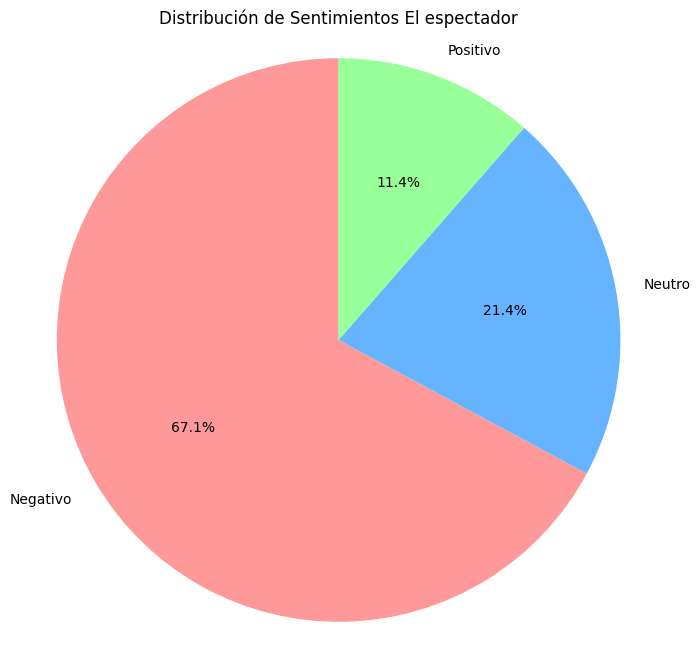

In [9]:
import matplotlib.pyplot as plt

# Contar la cantidad de ocurrencias de cada sentimiento
distribucion_sentimientos = datos_evaluacion_el_espectador['Sentimiento modelo'].value_counts()

# Crear la gráfica de torta
plt.figure(figsize=(8, 8))
plt.pie(distribucion_sentimientos, labels=distribucion_sentimientos.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribución de Sentimientos El espectador')
plt.axis('equal')  # Para que la torta sea un círculo
plt.show()


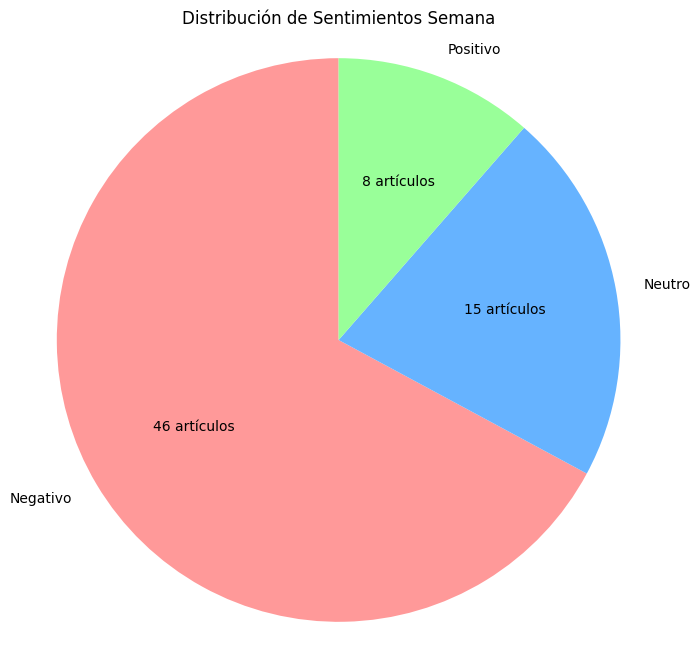

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Contar la cantidad de ocurrencias de cada sentimiento
distribucion_sentimientos = datos_evaluacion_el_espectador['Sentimiento modelo'].value_counts()

# Función para mostrar el número de artículos en lugar del porcentaje
def mostrar_cantidad(pct, allvals):
    absolute = int(pct / 100. * np.sum(allvals))
    return f"{absolute} artículos"

# Crear la gráfica de torta
plt.figure(figsize=(8, 8))
plt.pie(
    distribucion_sentimientos, 
    labels=distribucion_sentimientos.index, 
    autopct=lambda pct: mostrar_cantidad(pct, distribucion_sentimientos), 
    startangle=90, 
    colors=['#ff9999', '#66b3ff', '#99ff99']
)
plt.title('Distribución de Sentimientos Semana')
plt.axis('equal')  # Para que la torta sea un círculo
plt.show()


## La republica 

In [11]:
# Cargar el conjunto de datos de evaluación
ruta_datos_evaluacion = "C:\\Users\\USER\\Documents\\CIENCIA DE DATOS\\Proyecto aplicado\\PROYECTO POR PERIODICO\\datos_extraidoslarepublica_2023.csv"
datos_evaluacion_la_republica = pd.read_csv(ruta_datos_evaluacion)

# Cargar el tokenizer y el modelo entrenado
tokenizer = BertTokenizer.from_pretrained('model_reentrenado_v7')
model = BertForSequenceClassification.from_pretrained('model_reentrenado_v7')

# Mapear números de predicción a etiquetas de sentimiento
etiquetas = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

# Función para predecir el sentimiento
def predecir_sentimiento(texto):
    inputs = tokenizer(texto, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    return etiquetas.get(pred, 'Desconocido')

# Aplicar la función a la columna de texto
datos_evaluacion_la_republica['Sentimiento modelo'] = datos_evaluacion_la_republica['Texto Completo'].apply(predecir_sentimiento)

# Mostrar las primeras filas del DataFrame con las predicciones
datos_evaluacion_la_republica[['Texto Completo', 'Sentimiento modelo']]

,Texto Completo,Sentimiento modelo
0,"Toda persona es finita, falible e incierta. As...",Positivo
1,La paz total como política de gobierno fue una...,Negativo
2,Un negocio no es otra cosa que una transacción...,Neutro
3,Tiene que estar fuera de sus propios cabales u...,Negativo
4,Todos nos preguntamos ¿cómo podrá Colombia log...,Positivo
5,La paz ha sido el concepto que ha dominado el ...,Neutro
6,Desde mediados del mes de febrero nos encontra...,Neutro
7,"El título de este artículo, en tres palabras, ...",Positivo
8,"Este es el grito de batalla de Javier Milei, r...",Negativo
9,"Cuando hablamos de libertad económica, no nos ...",Neutro


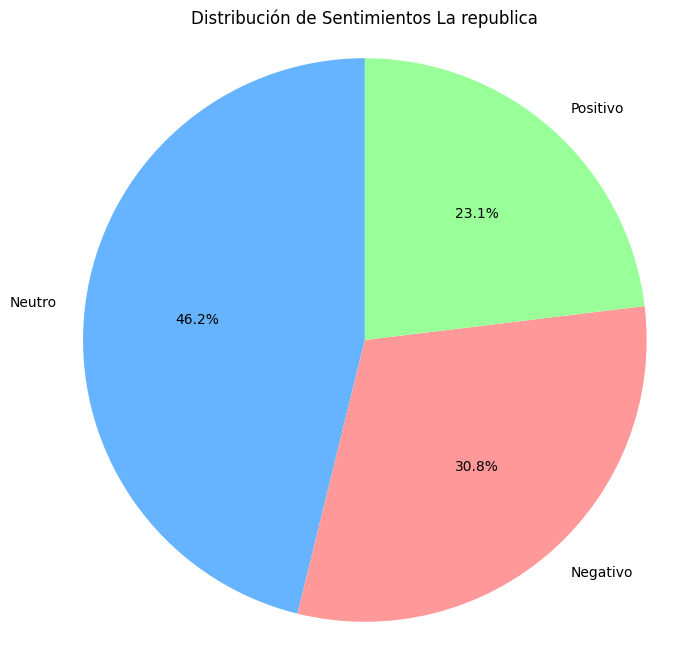

In [25]:
import matplotlib.pyplot as plt

# Contar la cantidad de ocurrencias de cada sentimiento
distribucion_sentimientos = datos_evaluacion_la_republica['Sentimiento modelo'].value_counts()

# Crear la gráfica de torta
plt.figure(figsize=(8, 8))
plt.pie(distribucion_sentimientos, labels=distribucion_sentimientos.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999','#99ff99'])
plt.title('Distribución de Sentimientos La republica')
plt.axis('equal')  # Para que la torta sea un círculo
plt.show()


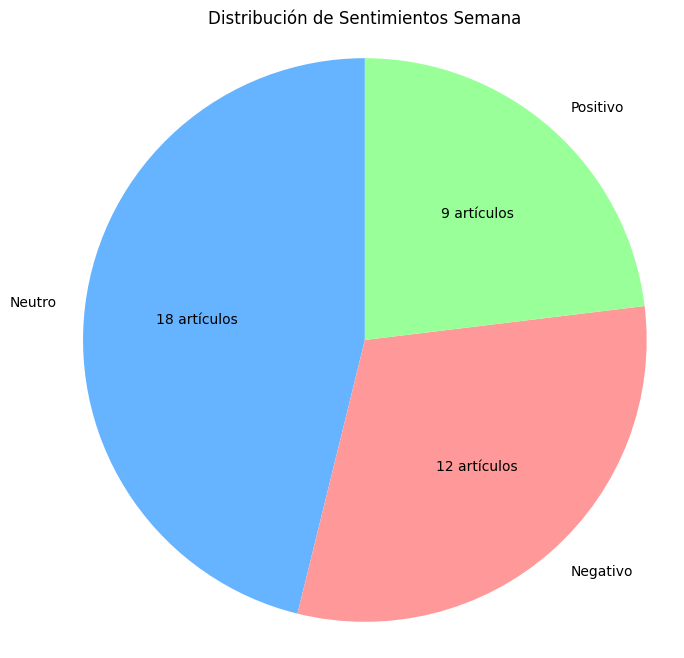

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Contar la cantidad de ocurrencias de cada sentimiento
distribucion_sentimientos = datos_evaluacion_la_republica['Sentimiento modelo'].value_counts()

# Función para mostrar el número de artículos en lugar del porcentaje
def mostrar_cantidad(pct, allvals):
    absolute = int(pct / 100. * np.sum(allvals))
    return f"{absolute} artículos"

# Crear la gráfica de torta
plt.figure(figsize=(8, 8))
plt.pie(
    distribucion_sentimientos, 
    labels=distribucion_sentimientos.index, 
    autopct=lambda pct: mostrar_cantidad(pct, distribucion_sentimientos), 
    startangle=90, 
    colors=['#66b3ff','#ff9999', '#99ff99']
)
plt.title('Distribución de Sentimientos Semana')
plt.axis('equal')  # Para que la torta sea un círculo
plt.show()


## Las 2 orillas 

In [14]:
# Cargar el conjunto de datos de evaluación
ruta_datos_evaluacion = "C:\\Users\\USER\\Documents\\CIENCIA DE DATOS\\Proyecto aplicado\\PROYECTO POR PERIODICO\\datos_extraidos_las2orillas_2023.csv"
datos_evaluacion_2orillas = pd.read_csv(ruta_datos_evaluacion)

# Cargar el tokenizer y el modelo entrenado
tokenizer = BertTokenizer.from_pretrained('model_reentrenado_v7')
model = BertForSequenceClassification.from_pretrained('model_reentrenado_v7')

# Mapear números de predicción a etiquetas de sentimiento
etiquetas = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

# Función para predecir el sentimiento
def predecir_sentimiento(texto):
    inputs = tokenizer(texto, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    return etiquetas.get(pred, 'Desconocido')

# Aplicar la función a la columna de texto
datos_evaluacion_2orillas['Sentimiento modelo'] = datos_evaluacion_2orillas['Texto Completo'].apply(predecir_sentimiento)

# Mostrar las primeras filas del DataFrame con las predicciones
datos_evaluacion_2orillas[['Texto Completo', 'Sentimiento modelo']]


,Texto Completo,Sentimiento modelo
0,Junto al replanteamiento de su política para l...,Negativo
1,"A Rueda no le faltan méritos académicos, a dif...",Negativo
2,"Contra todo pronóstico, las posturas más críti...",Neutro
3,Los jóvenes son atacados desde muchos frentes ...,Positivo
4,Plazos dados a la paz por el propio presidente...,Negativo
5,Palestina y Rusia tienen razones que deben ser...,Positivo
6,"Abandonar el proyecto de paz total, el más amb...",Neutro
7,A propósito del aniversario se llevará a cabo ...,Positivo
8,"""Hace meses usted me preguntaba qué era la paz...",Positivo
9,Si Kant asesorara a Petro en la negociación de...,Negativo


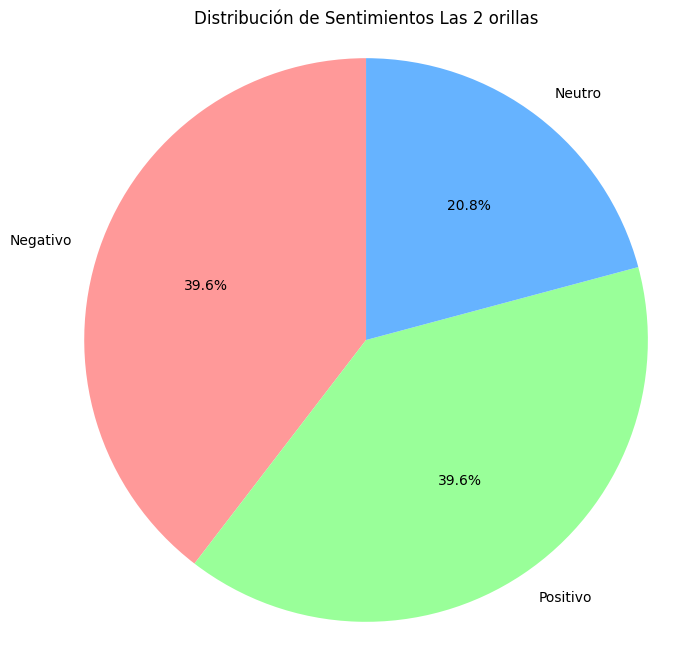

In [27]:
import matplotlib.pyplot as plt

# Contar la cantidad de ocurrencias de cada sentimiento
distribucion_sentimientos = datos_evaluacion_2orillas['Sentimiento modelo'].value_counts()

# Crear la gráfica de torta
plt.figure(figsize=(8, 8))
plt.pie(distribucion_sentimientos, labels=distribucion_sentimientos.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#99ff99','#66b3ff'])
plt.title('Distribución de Sentimientos Las 2 orillas')
plt.axis('equal')  # Para que la torta sea un círculo
plt.show()


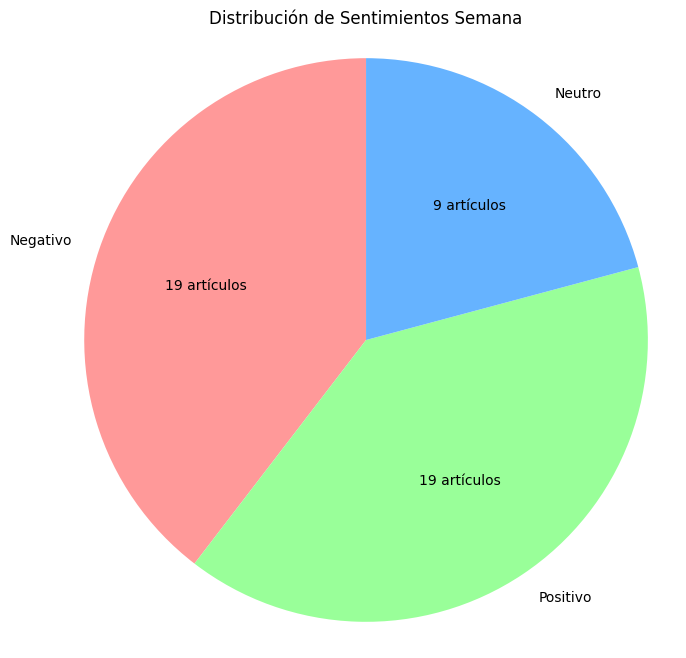

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Contar la cantidad de ocurrencias de cada sentimiento
distribucion_sentimientos = datos_evaluacion_2orillas['Sentimiento modelo'].value_counts()

# Función para mostrar el número de artículos en lugar del porcentaje
def mostrar_cantidad(pct, allvals):
    absolute = int(pct / 100. * np.sum(allvals))
    return f"{absolute} artículos"

# Crear la gráfica de torta
plt.figure(figsize=(8, 8))
plt.pie(
    distribucion_sentimientos, 
    labels=distribucion_sentimientos.index, 
    autopct=lambda pct: mostrar_cantidad(pct, distribucion_sentimientos), 
    startangle=90, 
    colors=['#ff9999','#99ff99', '#66b3ff']
)
plt.title('Distribución de Sentimientos Semana')
plt.axis('equal')  # Para que la torta sea un círculo
plt.show()


## Portafolio

In [17]:
# Cargar el conjunto de datos de evaluación
ruta_datos_evaluacion = "C:\\Users\\USER\\Documents\\CIENCIA DE DATOS\\Proyecto aplicado\\PROYECTO POR PERIODICO\\datos_extraidosportafolio_2023.csv"
datos_evaluacion_portafolio = pd.read_csv(ruta_datos_evaluacion)

# Cargar el tokenizer y el modelo entrenado
tokenizer = BertTokenizer.from_pretrained('model_reentrenado_v7')
model = BertForSequenceClassification.from_pretrained('model_reentrenado_v7')

# Mapear números de predicción a etiquetas de sentimiento
etiquetas = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

# Función para predecir el sentimiento
def predecir_sentimiento(texto):
    inputs = tokenizer(texto, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    return etiquetas.get(pred, 'Desconocido')

# Aplicar la función a la columna de texto
datos_evaluacion_portafolio['Sentimiento modelo'] = datos_evaluacion_portafolio['Texto Completo'].apply(predecir_sentimiento)

# Mostrar las primeras filas del DataFrame con las predicciones
datos_evaluacion_portafolio[['Texto Completo', 'Sentimiento modelo']]


,Texto Completo,Sentimiento modelo
0,Para lograr jugosas ganancias del narcotráfico...,Neutro
1,El término paz total acuñado por el Presidente...,Negativo
2,No cabe duda que uno de los más grandes desafí...,Negativo
3,"La liberación de Luis Manuel Díaz, padre del f...",Neutro
4,"A lo largo de la historia, Colombia se ha cara...",Negativo
5,La paz es una ambición de todos los seres huma...,Negativo
6,El Acuerdo de Paz con las Farc fue punto de pa...,Negativo
7,Siguiendo los juegos de palabras de los cuento...,Negativo
8,Las protestas de 2021 cambiaron a Colombia. En...,Positivo
9,El fin de semana pasado hechos en varios lugar...,Negativo


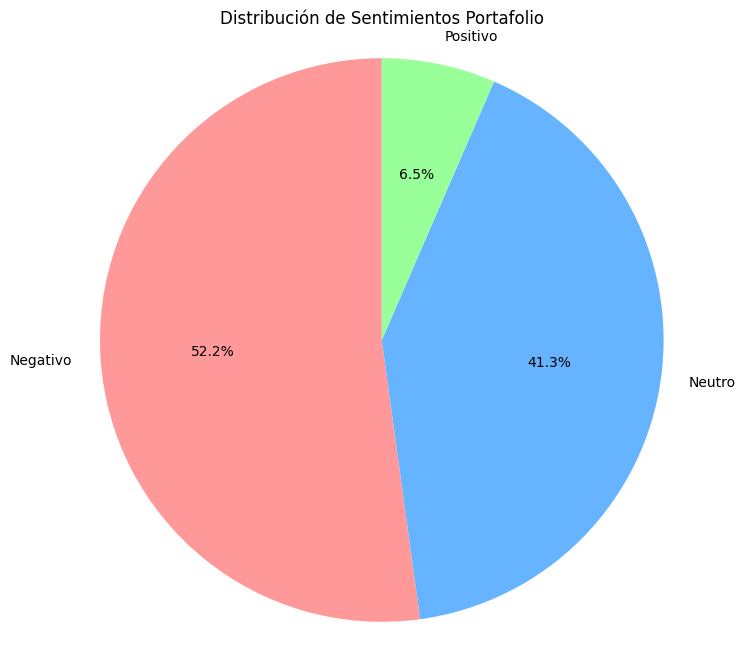

In [18]:
import matplotlib.pyplot as plt

# Contar la cantidad de ocurrencias de cada sentimiento
distribucion_sentimientos = datos_evaluacion_portafolio['Sentimiento modelo'].value_counts()

# Crear la gráfica de torta
plt.figure(figsize=(8, 8))
plt.pie(distribucion_sentimientos, labels=distribucion_sentimientos.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribución de Sentimientos Portafolio')
plt.axis('equal')  # Para que la torta sea un círculo
plt.show()


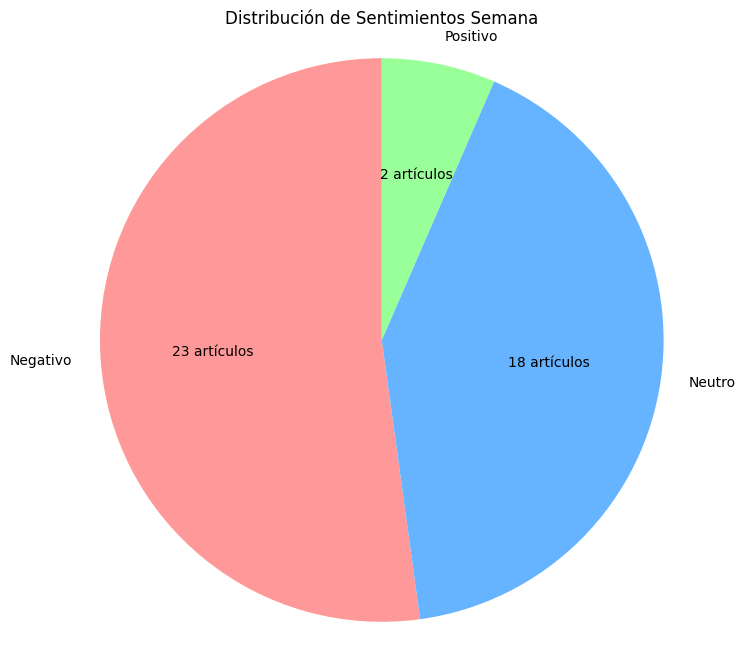

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Contar la cantidad de ocurrencias de cada sentimiento
distribucion_sentimientos = datos_evaluacion_portafolio['Sentimiento modelo'].value_counts()

# Función para mostrar el número de artículos en lugar del porcentaje
def mostrar_cantidad(pct, allvals):
    absolute = int(pct / 100. * np.sum(allvals))
    return f"{absolute} artículos"

# Crear la gráfica de torta
plt.figure(figsize=(8, 8))
plt.pie(
    distribucion_sentimientos, 
    labels=distribucion_sentimientos.index, 
    autopct=lambda pct: mostrar_cantidad(pct, distribucion_sentimientos), 
    startangle=90, 
    colors=['#ff9999', '#66b3ff', '#99ff99']
)
plt.title('Distribución de Sentimientos Semana')
plt.axis('equal')  # Para que la torta sea un círculo
plt.show()


## Semana

In [20]:
# Cargar el conjunto de datos de evaluación
ruta_datos_evaluacion = "C:\\Users\\USER\\Documents\\CIENCIA DE DATOS\\Proyecto aplicado\\PROYECTO POR PERIODICO\\datos_extraidossemana_2023.csv"
datos_evaluacion_semana = pd.read_csv(ruta_datos_evaluacion)

# Cargar el tokenizer y el modelo entrenado
tokenizer = BertTokenizer.from_pretrained('model_reentrenado_v7')
model = BertForSequenceClassification.from_pretrained('model_reentrenado_v7')

# Mapear números de predicción a etiquetas de sentimiento
etiquetas = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

# Función para predecir el sentimiento
def predecir_sentimiento(texto):
    inputs = tokenizer(texto, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    return etiquetas.get(pred, 'Desconocido')

# Aplicar la función a la columna de texto
datos_evaluacion_semana['Sentimiento modelo'] = datos_evaluacion_semana['Texto Completo'].apply(predecir_sentimiento)

# Mostrar las primeras filas del DataFrame con las predicciones
datos_evaluacion_semana[['Texto Completo', 'Sentimiento modelo']]


,Texto Completo,Sentimiento modelo
0,El asunto de la autonomía regional y la necesi...,Neutro
1,Dice “Antonio García” que el ELN es pobre pues...,Negativo
2,Un experto en temas de paz me hizo llegar el l...,Neutro
3,La idea de “paz total” del presidente Gustavo ...,Negativo
4,"El 7 de agosto, durante su discurso de posesió...",Negativo
5,La apuesta más grande que hoy se propone en Co...,Negativo
6,"La iniciativa de ‘paz total’ del gobierno, que...",Negativo
7,"La paz no solo es un derecho, también es un de...",Negativo
8,El llamado de atención de la vicepresidenta Fr...,Negativo
9,Fue precisamente en una entrevista a SEMANA qu...,Negativo


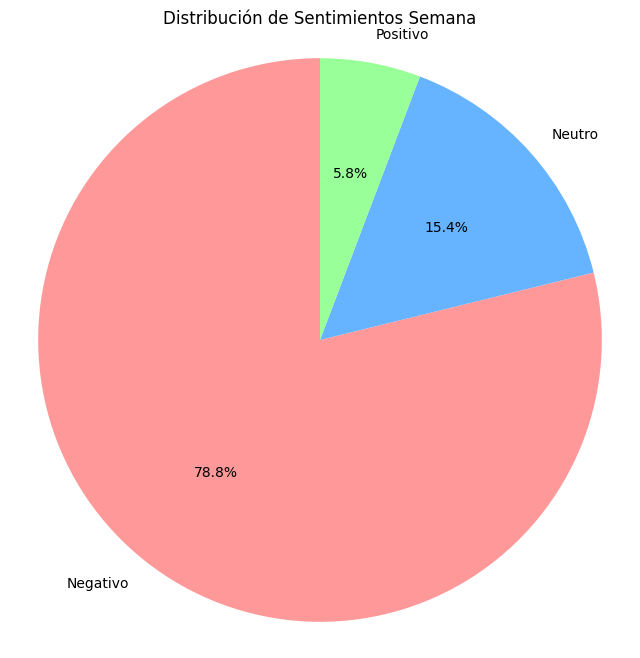

In [35]:
import matplotlib.pyplot as plt

# Contar la cantidad de ocurrencias de cada sentimiento
distribucion_sentimientos = datos_evaluacion_semana['Sentimiento modelo'].value_counts()

# Crear la gráfica de torta
plt.figure(figsize=(8, 8))
plt.pie(distribucion_sentimientos, labels=distribucion_sentimientos.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribución de Sentimientos Semana')
plt.axis('equal')  # Para que la torta sea un círculo
plt.show()


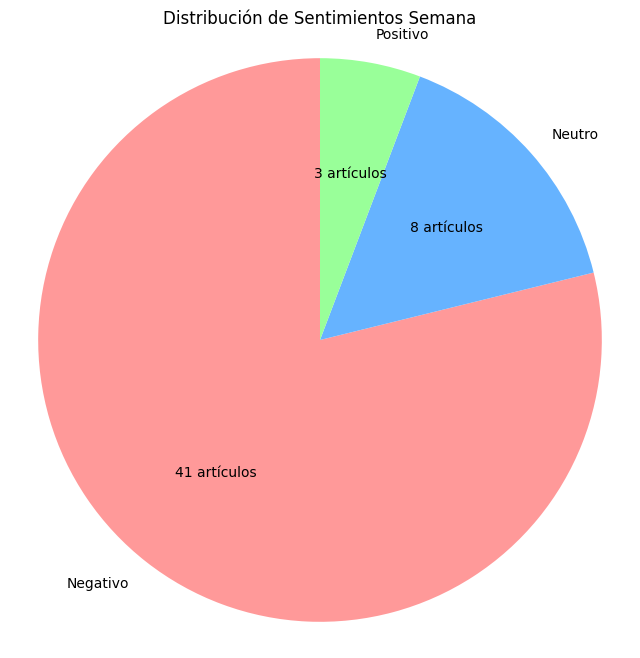

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Contar la cantidad de ocurrencias de cada sentimiento
distribucion_sentimientos = datos_evaluacion_semana['Sentimiento modelo'].value_counts()

# Función para mostrar el número de artículos en lugar del porcentaje
def mostrar_cantidad(pct, allvals):
    absolute = int(pct / 100. * np.sum(allvals))
    return f"{absolute} artículos"

# Crear la gráfica de torta
plt.figure(figsize=(8, 8))
plt.pie(
    distribucion_sentimientos, 
    labels=distribucion_sentimientos.index, 
    autopct=lambda pct: mostrar_cantidad(pct, distribucion_sentimientos), 
    startangle=90, 
    colors=['#ff9999', '#66b3ff', '#99ff99']
)
plt.title('Distribución de Sentimientos Semana')
plt.axis('equal')  # Para que la torta sea un círculo
plt.show()


## Unidos

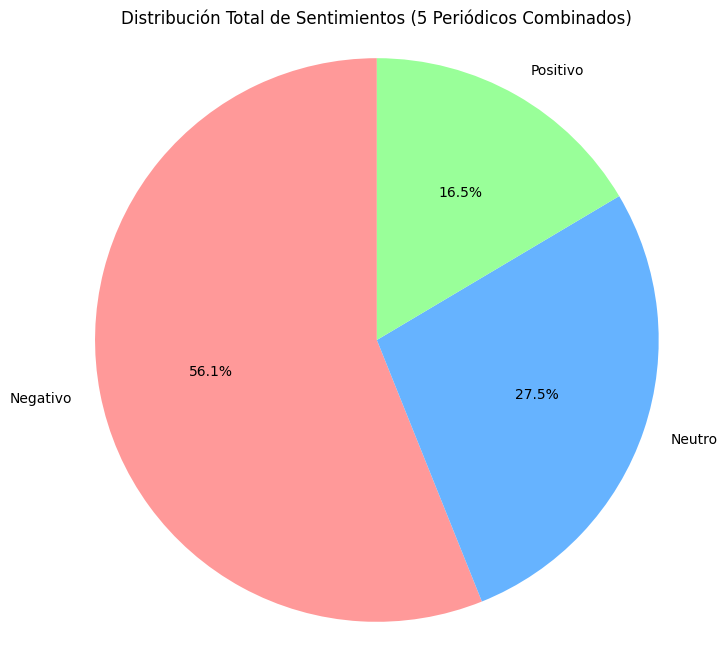

In [23]:
sentimientos_combined = pd.concat([
    datos_evaluacion_semana['Sentimiento modelo'],
    datos_evaluacion_portafolio['Sentimiento modelo'],
    datos_evaluacion_2orillas['Sentimiento modelo'],
    datos_evaluacion_la_republica['Sentimiento modelo'],
    datos_evaluacion_el_espectador['Sentimiento modelo']
])

# Contar la cantidad de ocurrencias de cada sentimiento en el conjunto combinado
distribucion_sentimientos_total = sentimientos_combined.value_counts()

# Crear la gráfica de torta
plt.figure(figsize=(8, 8))
plt.pie(
    distribucion_sentimientos_total, 
    labels=distribucion_sentimientos_total.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['#ff9999', '#66b3ff', '#99ff99']
)
plt.title('Distribución Total de Sentimientos (5 Periódicos Combinados)')
plt.axis('equal')  # Para que la torta sea un círculo
plt.show()


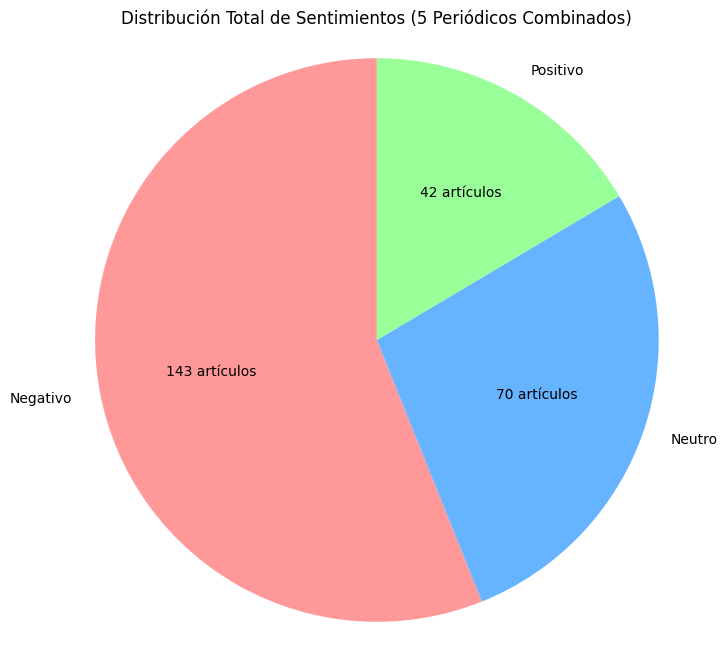

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Combinar los datos de los 5 periódicos en una sola columna de sentimientos
# Concatenar los sentimientos de cada periódico en una sola serie
sentimientos_combined = pd.concat([
    datos_evaluacion_semana['Sentimiento modelo'],
    datos_evaluacion_portafolio['Sentimiento modelo'],
    datos_evaluacion_2orillas['Sentimiento modelo'],
    datos_evaluacion_la_republica['Sentimiento modelo'],
    datos_evaluacion_el_espectador['Sentimiento modelo']
])

# Contar la cantidad de ocurrencias de cada sentimiento en el conjunto combinado
distribucion_sentimientos_total = sentimientos_combined.value_counts()

# Función para mostrar el número de artículos en lugar del porcentaje
def mostrar_cantidad(pct, allvals):
    absolute = int(pct / 100.*np.sum(allvals))
    return f"{absolute} artículos"

# Crear la gráfica de torta
plt.figure(figsize=(8, 8))
plt.pie(
    distribucion_sentimientos_total, 
    labels=distribucion_sentimientos_total.index, 
    autopct=lambda pct: mostrar_cantidad(pct, distribucion_sentimientos_total), 
    startangle=90, 
    colors=['#ff9999', '#66b3ff', '#99ff99']
)
plt.title('Distribución Total de Sentimientos (5 Periódicos Combinados)')
plt.axis('equal')  # Para que la torta sea un círculo
plt.show()


# INDICE

## Indice 1

In [45]:
# Contar la cantidad de cada sentimiento
N_positivos = distribucion_sentimientos_total.get('Positivo', 0)
N_neutros = distribucion_sentimientos_total.get('Neutro', 0)
N_negativos = distribucion_sentimientos_total.get('Negativo', 0)
N_total = N_positivos + N_neutros + N_negativos


# Calcular el Índice de Percepción de Paz
indice_percepcion_paz = ((N_positivos * 1) + (N_neutros * 0) + (N_negativos * -1)) / N_total

# Calcular el segundo Índice de Percepción de Paz
indice_percepcion_paz_2 = ((N_positivos - N_negativos) / N_total) * (1 - N_neutros / N_total)

# Calcular probabilidades
P_positivo = N_positivos / N_total
P_negativo = N_negativos / N_total
P_neutro = N_neutros / N_total

# Calcular el Índice de Percepción de Paz usando probabilidades
indice_percepcion_paz_prob = P_positivo - P_negativo + (P_neutro / 2)

# Calcular el índice final
indice_percepcion_paz_final = (P_positivo - P_negativo) / (1 + P_neutro)

# Imprimir resultados
print("Índice de Percepción de Paz (Método 1):", indice_percepcion_paz)
print("Índice de Percepción de Paz (Método 2):", indice_percepcion_paz_2)
print("Índice de Percepción de Paz (Método 3):", indice_percepcion_paz_prob)
print("Índice de Percepción de Paz (Método 4):", indice_percepcion_paz_final)


Índice de Percepción de Paz (Método 1): -0.396078431372549
Índice de Percepción de Paz (Método 2): -0.28735101883890807
Índice de Percepción de Paz (Método 3): -0.25882352941176473
Índice de Percepción de Paz (Método 4): -0.3107692307692308


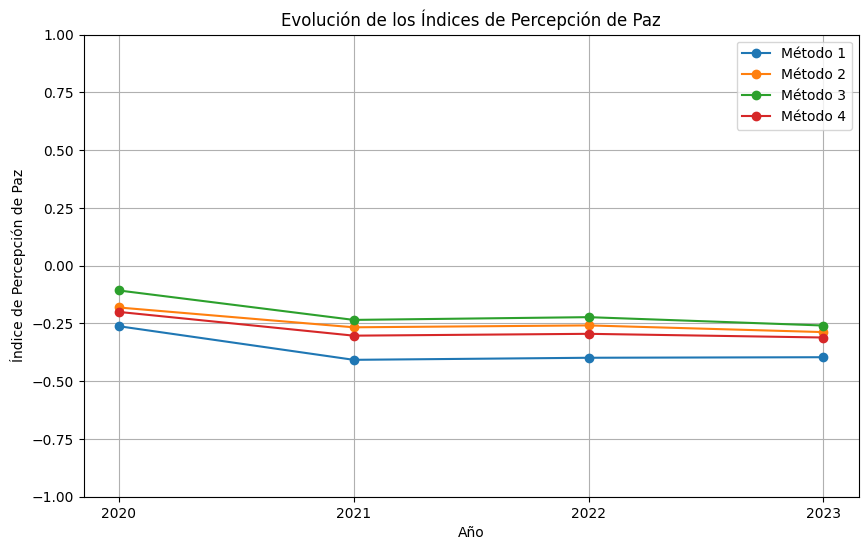

In [55]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt

# Cargar el tokenizer y el modelo entrenado
tokenizer = BertTokenizer.from_pretrained('model_reentrenado_v7')
model = BertForSequenceClassification.from_pretrained('model_reentrenado_v7')

# Mapear números de predicción a etiquetas de sentimiento
etiquetas = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

# Función para predecir el sentimiento
def predecir_sentimiento(texto):
    inputs = tokenizer(texto, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    return etiquetas.get(pred, 'Desconocido')

# Leer el archivo de Excel con 3 hojas
archivo_excel = r"C:\Users\USER\Documents\CIENCIA DE DATOS\Proyecto aplicado\INDICADOR\datos_entrenamiento_concatenados.xlsx"
hojas = pd.read_excel(archivo_excel, sheet_name=['2020', '2021', '2022', '2023'])

# Crear un DataFrame para almacenar los resultados de cada año
resultados = []

# Procesar cada hoja y calcular los índices de percepción de paz
for año, datos in hojas.items():
    # Evaluar el sentimiento para cada texto
    datos['Sentimiento modelo'] = datos['Texto Completo'].apply(predecir_sentimiento)
    
    # Calcular la distribución de sentimientos
    distribucion_sentimientos = datos['Sentimiento modelo'].value_counts()
    N_positivos = distribucion_sentimientos.get('Positivo', 0)
    N_neutros = distribucion_sentimientos.get('Neutro', 0)
    N_negativos = distribucion_sentimientos.get('Negativo', 0)
    N_total = N_positivos + N_neutros + N_negativos
    
    # Calcular los índices de percepción de paz
    if N_total > 0:
        indice_percepcion_paz = ((N_positivos * 1) + (N_neutros * 0) + (N_negativos * -1)) / N_total
        indice_percepcion_paz_2 = ((N_positivos - N_negativos) / N_total) * (1 - N_neutros / N_total)
        P_positivo = N_positivos / N_total
        P_negativo = N_negativos / N_total
        P_neutro = N_neutros / N_total
        indice_percepcion_paz_prob = P_positivo - P_negativo + (P_neutro / 2)
        indice_percepcion_paz_final = (P_positivo - P_negativo) / (1 + P_neutro)
        
        # Almacenar los resultados en una lista
        resultados.append({
            'Año': año,
            'Método 1': indice_percepcion_paz,
            'Método 2': indice_percepcion_paz_2,
            'Método 3': indice_percepcion_paz_prob,
            'Método 4': indice_percepcion_paz_final
        })

# Convertir los resultados en un DataFrame
df_resultados = pd.DataFrame(resultados)

# Graficar la evolución de los cuatro indicadores
plt.figure(figsize=(10, 6))
plt.plot(df_resultados['Año'], df_resultados['Método 1'], marker='o', label='Método 1')
plt.plot(df_resultados['Año'], df_resultados['Método 2'], marker='o', label='Método 2')
plt.plot(df_resultados['Año'], df_resultados['Método 3'], marker='o', label='Método 3')
plt.plot(df_resultados['Año'], df_resultados['Método 4'], marker='o', label='Método 4')
plt.xlabel('Año')
plt.ylabel('Índice de Percepción de Paz')
plt.title('Evolución de los Índices de Percepción de Paz')
plt.ylim(-1, 1) 
plt.legend()
plt.grid(True)
plt.show()


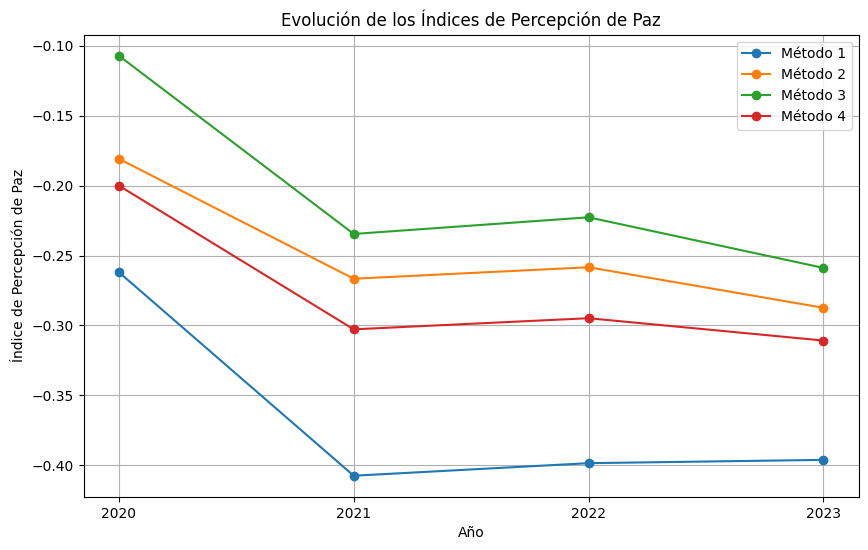

In [56]:
# Graficar la evolución de los cuatro indicadores
plt.figure(figsize=(10, 6))
plt.plot(df_resultados['Año'], df_resultados['Método 1'], marker='o', label='Método 1')
plt.plot(df_resultados['Año'], df_resultados['Método 2'], marker='o', label='Método 2')
plt.plot(df_resultados['Año'], df_resultados['Método 3'], marker='o', label='Método 3')
plt.plot(df_resultados['Año'], df_resultados['Método 4'], marker='o', label='Método 4')
plt.xlabel('Año')
plt.ylabel('Índice de Percepción de Paz')
plt.title('Evolución de los Índices de Percepción de Paz')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# Imprimir la tabla de resultados
print("Tabla de Índices de Percepción de Paz por Año:")
df_resultados

Tabla de Índices de Percepción de Paz por Año:


,Año,Método 1,Método 2,Método 3,Método 4
0,2020,-0.261905,-0.180839,-0.107143,-0.200000
1,2021,-0.407407,-0.266575,-0.234568,-0.302752
2,2022,-0.398438,-0.258362,-0.222656,-0.294798
3,2023,-0.396078,-0.287351,-0.258824,-0.310769


## Indice#2

In [27]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt

# Cargar el tokenizer y el modelo entrenado
tokenizer = BertTokenizer.from_pretrained('model_reentrenado_v7')
model = BertForSequenceClassification.from_pretrained('model_reentrenado_v7')

# Mapear números de predicción a etiquetas de sentimiento
etiquetas = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

# Función para predecir el sentimiento
def predecir_sentimiento(texto):
    inputs = tokenizer(texto, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    return etiquetas.get(pred, 'Desconocido')

# Cargar el archivo Excel con varias hojas
archivo_excel = r"C:\Users\USER\Documents\CIENCIA DE DATOS\Proyecto aplicado\INDICADOR\datos_entrenamiento_concatenados_año_periodico.xlsx"
hojas = pd.read_excel(archivo_excel, sheet_name=None)

# Crear un DataFrame para almacenar los resultados de cada año y periódico
resultados = []

# Procesar cada hoja por año
for año, datos in hojas.items():
    # Agrupar los datos por periódico
    for periodico, grupo in datos.groupby('Periodico'):
        # Evaluar el sentimiento para cada texto
        grupo['Sentimiento modelo'] = grupo['Texto Completo'].apply(predecir_sentimiento)
        
        # Calcular la distribución de sentimientos
        distribucion_sentimientos = grupo['Sentimiento modelo'].value_counts()
        N_positivos = distribucion_sentimientos.get('Positivo', 0)
        N_neutros = distribucion_sentimientos.get('Neutro', 0)
        N_negativos = distribucion_sentimientos.get('Negativo', 0)
        N_total = N_positivos + N_neutros + N_negativos
        
        # Calcular los índices de percepción de paz
        if N_total > 0:
            indice_percepcion_paz = ((N_positivos * 1) + (N_neutros * 0) + (N_negativos * -1)) / N_total
            indice_percepcion_paz_2 = ((N_positivos - N_negativos) / N_total) * (1 - N_neutros / N_total)
            P_positivo = N_positivos / N_total
            P_negativo = N_negativos / N_total
            P_neutro = N_neutros / N_total
            indice_percepcion_paz_prob = P_positivo - P_negativo + (P_neutro / 2)
            indice_percepcion_paz_final = (P_positivo - P_negativo) / (1 + P_neutro)
            
            # Almacenar los resultados
            resultados.append({
                'Año': año,
                'Periódico': periodico,
                'Método 1': indice_percepcion_paz,
                'Método 2': indice_percepcion_paz_2,
                'Método 3': indice_percepcion_paz_prob,
                'Método 4': indice_percepcion_paz_final
            })

# Convertir los resultados en un DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados


,Año,Periódico,Método 1,Método 2,Método 3,Método 4
0,2020,ESPECTADOR,-0.321429,-0.286990,-0.267857,-0.290323
1,2020,LAS2ORILLAS,0.000000,0.000000,0.208333,0.000000
2,2020,PORTAFOLIO,0.000000,0.000000,0.285714,0.000000
3,2020,REPUBLICA,-0.500000,-0.250000,-0.250000,-0.333333
4,2020,SEMANA,-0.785714,-0.617347,-0.678571,-0.647059
5,2021,ESPECTADOR,-0.454545,-0.330579,-0.318182,-0.357143
6,2021,LAS2ORILLAS,-0.521739,-0.272212,-0.282609,-0.352941
7,2021,PORTAFOLIO,-0.384615,-0.266272,-0.230769,-0.294118
8,2021,REPUBLICA,-0.266667,-0.177778,-0.100000,-0.200000
9,2021,SEMANA,-0.250000,-0.187500,-0.125000,-0.200000


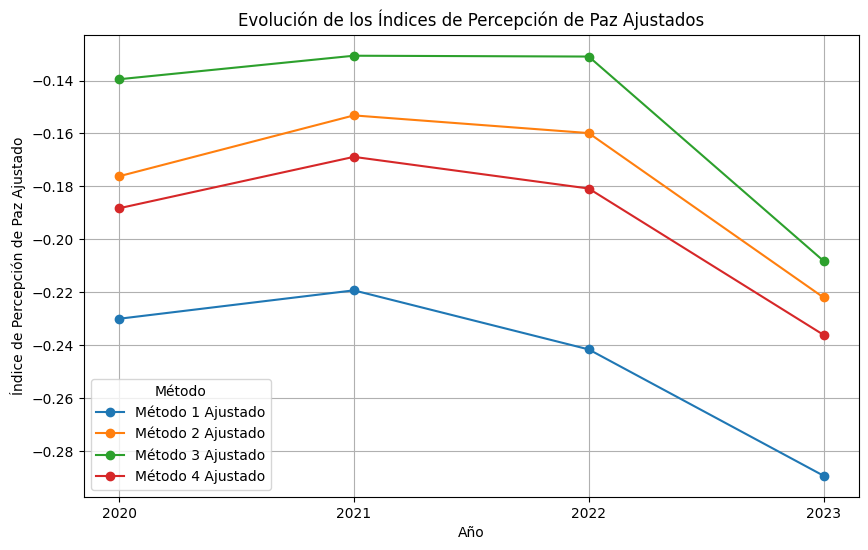

In [ ]:
# Asignar el ranking de popularidad (incluyendo un periódico ficticio en la posición 6)
ranking_scimago = {'ESPECTADOR': 1, 'SEMANA': 2, 'PORTAFOLIO': 3, 'REPUBLICA': 4, 'LAS2ORILLAS': 5}
max_rank = 6  # Incluimos un "periódico adicional" para la normalización

# Añadir columna de popularidad normalizada considerando un periódico adicionalX
df_resultados['Popularidad Normalizada'] = df_resultados['Periódico'].map(
    lambda x: 1 - (ranking_scimago.get(x, max_rank) - 1) / (max_rank - 1)
)

# Ajustar cada método con la popularidad normalizada
for metodo in ['Método 1', 'Método 2', 'Método 3', 'Método 4']:
    df_resultados[f'{metodo} Ajustado'] = df_resultados[metodo] * df_resultados['Popularidad Normalizada']

# Calcular el promedio ajustado por año para cada método
df_ajustado_por_año = df_resultados.groupby('Año')[[f'{metodo} Ajustado' for metodo in ['Método 1', 'Método 2', 'Método 3', 'Método 4']]].mean().reset_index()

# Graficar los resultados ajustados por año
plt.figure(figsize=(10, 6))
for metodo in ['Método 1 Ajustado', 'Método 2 Ajustado', 'Método 3 Ajustado', 'Método 4 Ajustado']:
    plt.plot(df_ajustado_por_año['Año'], df_ajustado_por_año[metodo], marker='o', label=metodo)

plt.title("Evolución de los Índices de Percepción de Paz Ajustados")
plt.xlabel("Año")
plt.ylabel("Índice de Percepción de Paz Ajustado")
plt.legend(title="Método")
plt.grid(True)
plt.show()



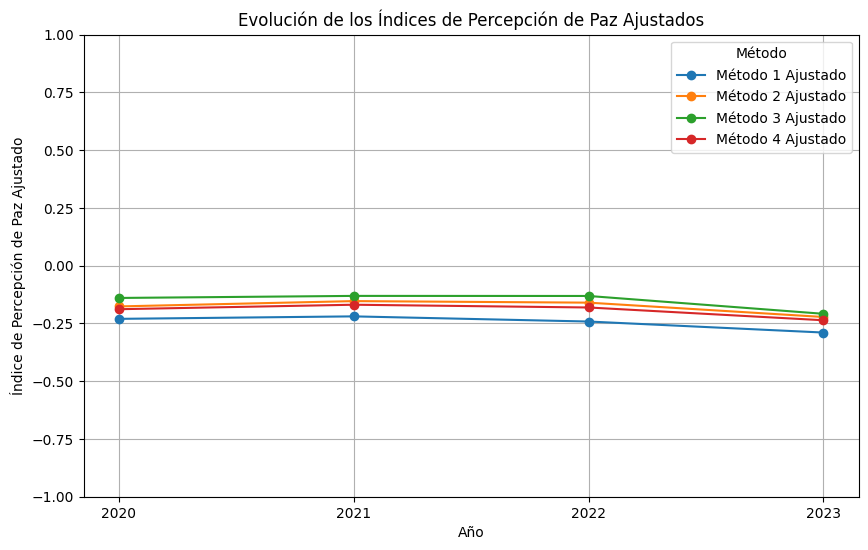

In [24]:
# Graficar los resultados ajustados por año
plt.figure(figsize=(10, 6))
for metodo in ['Método 1 Ajustado', 'Método 2 Ajustado', 'Método 3 Ajustado', 'Método 4 Ajustado']:
    plt.plot(df_ajustado_por_año['Año'], df_ajustado_por_año[metodo], marker='o', label=metodo)

plt.title("Evolución de los Índices de Percepción de Paz Ajustados")
plt.xlabel("Año")
plt.ylabel("Índice de Percepción de Paz Ajustado")
plt.legend(title="Método")
plt.grid(True)
plt.ylim(-1, 1) 
plt.show()


## indice #3

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt

# Cargar el tokenizer y el modelo entrenado
tokenizer = BertTokenizer.from_pretrained('model_reentrenado_v7')
model = BertForSequenceClassification.from_pretrained('model_reentrenado_v7')

# Mapear números de predicción a etiquetas de sentimiento
etiquetas = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

# Función para predecir el sentimiento
def predecir_sentimiento(texto):
    inputs = tokenizer(texto, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    return etiquetas.get(pred, 'Desconocido')

# Cargar el archivo Excel con varias hojas
archivo_excel = r"C:\Users\USER\Documents\CIENCIA DE DATOS\Proyecto aplicado\INDICADOR\datos_entrenamiento_concatenados_año_periodico.xlsx"
hojas = pd.read_excel(archivo_excel, sheet_name=None)

# Crear un DataFrame para almacenar los resultados de cada año y periódico
resultados = []

# Procesar cada hoja por año
for año, datos in hojas.items():
    # Agrupar los datos por periódico
    for periodico, grupo in datos.groupby('Periodico'):
        # Evaluar el sentimiento para cada texto
        grupo['Sentimiento modelo'] = grupo['Texto Completo'].apply(predecir_sentimiento)
        
        # Calcular la distribución de sentimientos
        distribucion_sentimientos = grupo['Sentimiento modelo'].value_counts()
        N_positivos = distribucion_sentimientos.get('Positivo', 0)
        N_neutros = distribucion_sentimientos.get('Neutro', 0)
        N_negativos = distribucion_sentimientos.get('Negativo', 0)
        N_total = N_positivos + N_neutros + N_negativos
        
        # Calcular los índices de percepción de paz
        if N_total > 0:
            indice_percepcion_paz = ((N_positivos * 1) + (N_neutros * 0) + (N_negativos * -1)) / N_total
            indice_percepcion_paz_2 = ((N_positivos - N_negativos) / N_total) * (1 - N_neutros / N_total)
            P_positivo = N_positivos / N_total
            P_negativo = N_negativos / N_total
            P_neutro = N_neutros / N_total
            indice_percepcion_paz_prob = P_positivo - P_negativo + (P_neutro / 2)
            indice_percepcion_paz_final = (P_positivo - P_negativo) / (1 + P_neutro)
            
            # Almacenar los resultados
            resultados.append({
                'Año': año,
                'Periódico': periodico,
                'Método 1': indice_percepcion_paz,
                'Método 2': indice_percepcion_paz_2,
                'Método 3': indice_percepcion_paz_prob,
                'Método 4': indice_percepcion_paz_final
            })

# Convertir los resultados en un DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados


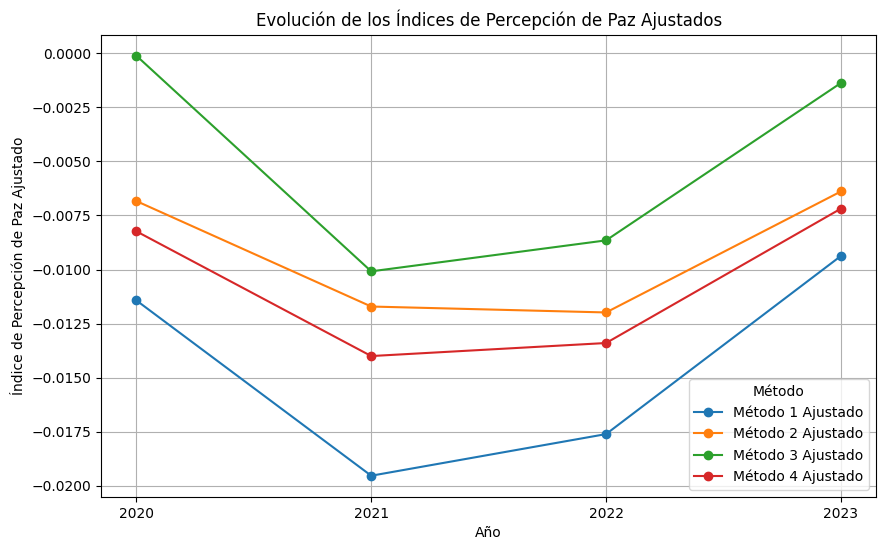

In [28]:
# Ranking de popularidad
ranking_scimago = {'ESPECTADOR': 1, 'SEMANA': 2, 'PORTAFOLIO': 3, 'REPUBLICA': 4, 'LAS2ORILLAS': 5}
max_rank = 6  # Incluimos un "periódico adicional" para la normalización

# Asignamos un ranking a un periódico ficticio
df_resultados = df_resultados.copy()
df_resultados['Popularidad'] = df_resultados['Periódico'].map(ranking_scimago).fillna(max_rank)

# Normalización para que la suma de los valores sea 1, evitando el cero
ranking_min = df_resultados['Popularidad'].min()
ranking_sum = (df_resultados['Popularidad'] - ranking_min).sum()

df_resultados['Popularidad Normalizada'] = (df_resultados['Popularidad'] - ranking_min) / ranking_sum

# Ajustar cada método con la popularidad normalizada
for metodo in ['Método 1', 'Método 2', 'Método 3', 'Método 4']:
    df_resultados[f'{metodo} Ajustado'] = df_resultados[metodo] * df_resultados['Popularidad Normalizada']

# Calcular el promedio ajustado por año para cada método
df_ajustado_por_año = df_resultados.groupby('Año')[[f'{metodo} Ajustado' for metodo in ['Método 1', 'Método 2', 'Método 3', 'Método 4']]].mean().reset_index()

# Graficar los resultados ajustados por año
plt.figure(figsize=(10, 6))
for metodo in ['Método 1 Ajustado', 'Método 2 Ajustado', 'Método 3 Ajustado', 'Método 4 Ajustado']:
    plt.plot(df_ajustado_por_año['Año'], df_ajustado_por_año[metodo], marker='o', label=metodo)

plt.title("Evolución de los Índices de Percepción de Paz Ajustados")
plt.xlabel("Año")
plt.ylabel("Índice de Percepción de Paz Ajustado")
plt.legend(title="Método")
plt.grid(True)
plt.show()


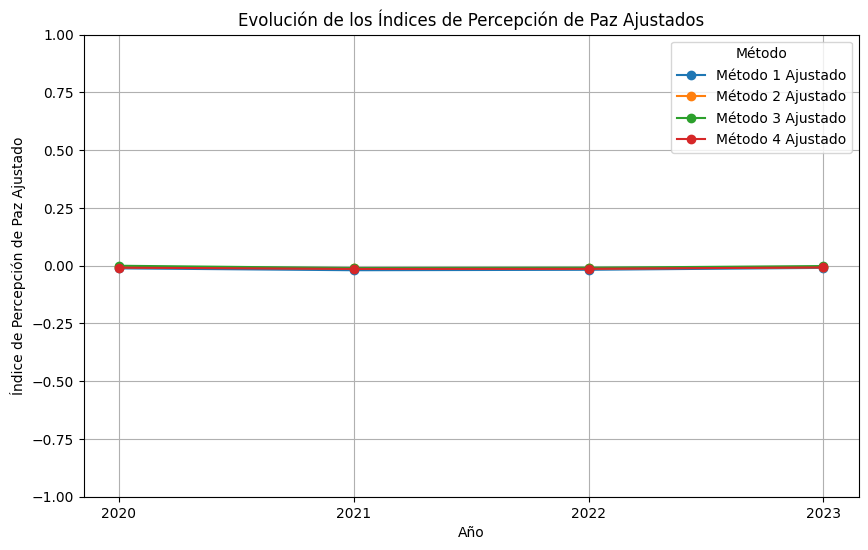

In [29]:
# Graficar los resultados ajustados por año
plt.figure(figsize=(10, 6))
for metodo in ['Método 1 Ajustado', 'Método 2 Ajustado', 'Método 3 Ajustado', 'Método 4 Ajustado']:
    plt.plot(df_ajustado_por_año['Año'], df_ajustado_por_año[metodo], marker='o', label=metodo)

plt.title("Evolución de los Índices de Percepción de Paz Ajustados")
plt.xlabel("Año")
plt.ylabel("Índice de Percepción de Paz Ajustado")
plt.legend(title="Método")
plt.grid(True)
plt.ylim(-1, 1) 
plt.show()
